**Medical Image Classification: Hello World Deep Learning Tutorial**

**Prepare data using the MD.ai python client, train using Keras**
This is a high-level introduction into practical machine learning for purposes of medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between chest and abdominal X-rays. The model is trained using 75 images de-identified images obtained from Open-i.

Original github repo this is based on: https://github.com/ImagingInformatics/machine-learning

MD.ai annotator project URL: https://public.md.ai/annotator/project/PVq9raBJ

How to use on Colab: in the menu, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.

**Import the mdai library**
On Colab, run the block below to install the mdai client library into your python environment.

In [0]:
pip install --upgrade --quiet mdai

In [6]:
import mdai
mdai.__version__

'0.4.1'

**Create an mdai client**

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [7]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="891bbada94210299c2bb5aa018303ecb")

Successfully authenticated to public.md.ai.


**Define project**

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: https://public.md.ai/annotator/project/{project_id}.

For example, project_id would be PVq9raBJ for https://public.md.ai/annotator/project/PVq9raBJ.

Specify optional path as the data directory (if left blank, will default to current working directory).

In [8]:

p = mdai_client.project('PVq9raBJ', path='/data/HelloWorld')

Using path '/data/HelloWorld' for data.
Preparing annotations export for project PVq9raBJ...                                                
Preparing images export for project PVq9raBJ...                                                     


64.0kB [00:00, 18.1MB/s]                   


Success: annotations data for project PVq9raBJ ready.


2.62MB [00:00, 31.4MB/s]                   

Extracting archive: mdai_public_project_PVq9raBJ_images_2018-09-16-022030.zip
Success: images data for project PVq9raBJ ready.


**Set label ids**

Selected label ids must be explicitly set by Project#set_label_ids method in order to prepare datasets.

In [9]:
p.show_label_groups()

Label Group, Id: G_BdW4M5, Name: Default group
	Labels:
	Id: L_38Y7Jl, Name: Abdomen
	Id: L_z8xEkB, Name: Chest



In [10]:

# this maps label ids to class ids as a dict obj
labels_dict = {'L_38Y7Jl':0, # Abdomen 
               'L_z8xEkB':1, # Chest  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_38Y7Jl': 0, 'L_z8xEkB': 1}


**Create the Training and Validation datasets**

In [11]:
p.show_datasets()

Datasets:
Id: D_8ogmzN, Name: TRAIN
Id: D_OoJ98E, Name: VAL
Id: D_8oAvmQ, Name: TEST



In [12]:
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()
print(len(train_image_ids))

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))

65
10


**Display a few images**

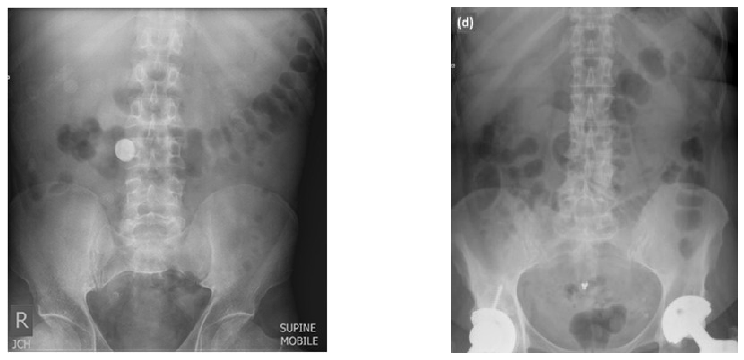

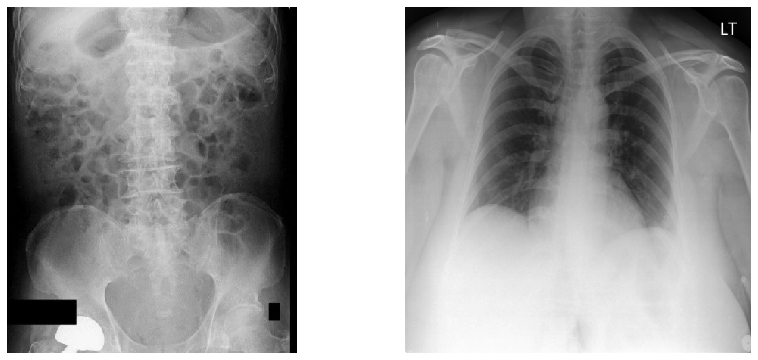

In [13]:
# visualize a few train images 
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

**Use Keras for training and validation**

In [14]:
from keras import applications
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
# Define model parameters 
img_width = 192
img_height = 192
epochs = 20

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [16]:
base_model = applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])












17227776/17225924 [==============================] - 0s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
from mdai.utils import keras_utils

train_generator = keras_utils.DataGenerator(train_dataset, **params)
val_generator = keras_utils.DataGenerator(val_dataset, **params)

In [0]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [20]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=2),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)

Epoch 1/20
13/13 [==============================] - 2s 142ms/step - loss: 0.0782 - acc: 0.9846 - val_loss: 0.0083 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00828, saving model to best_model.h5
Epoch 2/20
12/13 [==========================>...] - ETA: 0s - loss: 0.0552 - acc: 1.0000
Epoch 00001: val_loss improved from inf to 0.00828, saving model to best_model.h5
13/13 [==============================] - 1s 105ms/step - loss: 0.0517 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00828 to 0.00814, saving model to best_model.h5
Epoch 3/20
12/13 [==========================>...] - ETA: 0s - loss: 0.0376 - acc: 0.9833
Epoch 00002: val_loss improved from 0.00828 to 0.00814, saving model to best_model.h5
13/13 [==============================] - 1s 108ms/step - loss: 0.0386 - acc: 0.9846 - val_loss: 0.0071 - val_acc: 1.0000

Epoch 00003: val_loss improved f

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


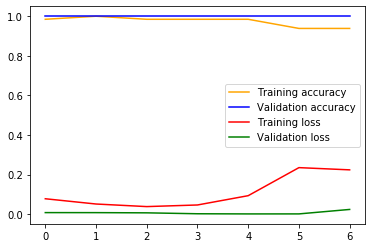

In [21]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

**Create the Test dataset**

In [0]:

model.load_weights('best_model.h5')

In [0]:
test_dataset = p.get_dataset_by_name('TEST')
test_dataset.prepare()

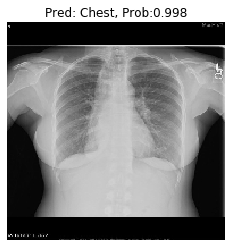

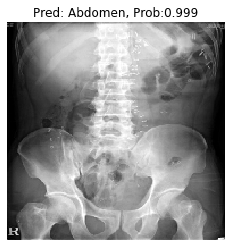

In [24]:
import numpy as np
#from skimage.transform import resize
from PIL import Image 

for image_id in test_dataset.image_ids: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()